In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [43]:
path = '/home/lucaspancotto/code/JoacoSoulez/mental_health_first_aid_evaluation/data/twitter_reddit_text.csv'
core_path = '/home/lucaspancotto/code/JoacoSoulez/mental_health_first_aid_evaluation/data/sorted_coefs_naivebayes_twitterreddit.csv'
data= pd.read_csv(f'{path}')
core_data = pd.read_csv(f'{core_path}')




In [70]:
core_data.head(30)

,Unnamed: 0,0
0,feel,-4.990164
1,depress,-5.006754
2,like,-5.237492
3,want,-5.350858
4,get,-5.560917
5,life,-5.566263
6,know,-5.591696
7,go,-5.640298
8,not,-5.735271
9,can,-5.735307


In [45]:
core_words = core_data['Unnamed: 0'].to_list()[0:100]

In [46]:
len(core_words)

100

In [47]:
data.head()

,Unnamed: 0,clean_text,label
0,0,lay bed hour point back pain get work minut cl...,1
1,1,dlitedaili dont play wouldnt want anyth world,0
2,2,rewebcoach hey handsom time get day go,0
3,3,get readi tenni maryyi,0
4,4,hear song band almost never play favourit radi...,0


In [48]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

In [49]:
def stop_core_words(txt):
    txt = word_tokenize(str(txt))
    txt = ' '.join(word for word in txt if not word in core_words)
    return txt

In [50]:
stop_core_words('depress my goodness oh fuck')

'my goodness oh'

In [51]:
data_stopped = data.clean_text.apply(stop_core_words)

In [52]:
data_stopped

0        lay bed hour minut clock motiv liter stare put...
1                       dlitedaili dont play wouldnt world
2                                   rewebcoach hey handsom
3                                       readi tenni maryyi
4           hear song band almost play favourit radio mood
                               ...                        
25363                           honestli convers post grad
25364           ye ye thank god u answer prayer asap owe u
25365                                        play game lol
25366    late l high stress interview dream today despi...
25367                 thank burghrealtor pghjen pie remend
Name: clean_text, Length: 25368, dtype: object

In [54]:
X = data_stopped
y = data.label

X_train, X_test, y_train, y_test = train_test_split(X , y ,test_size = 0.3 )
print('length of X_train',len(X_train), 'length of X_test',len(X_test), 'length of y_train',len(y_train), 'length of y_test',len(y_test))

X_train = [word_tokenize(str(_)) for _ in X_train]
X_test = [word_tokenize(str(_)) for _ in X_test]


length of X_train 17757 length of X_test 7611 length of y_train 17757 length of y_test 7611


# embed data

In [59]:
# This line trains an entire embedding for the words in your train set
word2vec = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=5)

def embed_sentence(word2vec, sentence):
    # $CHALLENGIFY_BEGIN
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)
def embedding(word2vec, sentences):
    # $CHALLENGIFY_BEGIN
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed
    # $CHALLENGIFY_END
    
X_train = embedding(word2vec, X_train)
X_test = embedding(word2vec, X_test)


In [61]:
#cortamos en 400 words
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_pad = pad_sequences(X_train, dtype='float', padding='post', maxlen= 400,truncating= 'post')
X_test_pad = pad_sequences(X_test, dtype='float', padding='post', maxlen = 400 , truncating = 'post')


2022-03-09 15:11:08.386038: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-09 15:11:08.386088: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# model rnn

In [62]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy', 'AUC','Precision','Recall'])
    
    return model

model = init_model()

2022-03-09 15:18:12.495446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-09 15:18:12.497273: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-09 15:18:12.499046: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-QMHRL2V): /proc/driver/nvidia/version does not exist
2022-03-09 15:18:12.532739: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [63]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3, restore_best_weights=True)

history_fit = model.fit(X_train_pad, y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
          verbose = 1
         )

2022-03-09 15:18:47.977076: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1988640000 exceeds 10% of free system memory.


Epoch 1/100
389/389 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.8999 - auc: 0.9532 - precision: 0.9283 - recall: 0.8659

2022-03-09 15:23:25.034531: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 852480000 exceeds 10% of free system memory.


389/389 [==============================] - 133s 302ms/step - loss: 0.2598 - accuracy: 0.8999 - auc: 0.9532 - precision: 0.9283 - recall: 0.8659 - val_loss: 0.2084 - val_accuracy: 0.9244 - val_auc: 0.9670 - val_precision: 0.9546 - val_recall: 0.8924
Epoch 2/100
389/389 [==============================] - 111s 285ms/step - loss: 0.2091 - accuracy: 0.9187 - auc: 0.9672 - precision: 0.9503 - recall: 0.8830 - val_loss: 0.2399 - val_accuracy: 0.9125 - val_auc: 0.9621 - val_precision: 0.9797 - val_recall: 0.8440
Epoch 3/100
389/389 [==============================] - 114s 292ms/step - loss: 0.2009 - accuracy: 0.9220 - auc: 0.9701 - precision: 0.9542 - recall: 0.8857 - val_loss: 0.1954 - val_accuracy: 0.9279 - val_auc: 0.9704 - val_precision: 0.9615 - val_recall: 0.8928
Epoch 4/100
389/389 [==============================] - 112s 288ms/step - loss: 0.1978 - accuracy: 0.9217 - auc: 0.9710 - precision: 0.9520 - recall: 0.8875 - val_loss: 0.1921 - val_accuracy: 0.9259 - val_auc: 0.9724 - val_precisi

In [66]:
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    #ax1.set_ylim(ymin=0, ymax=200)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('Epoch')
    #ax2.set_ylim(ymin=0, ymax=20)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    plt.show()



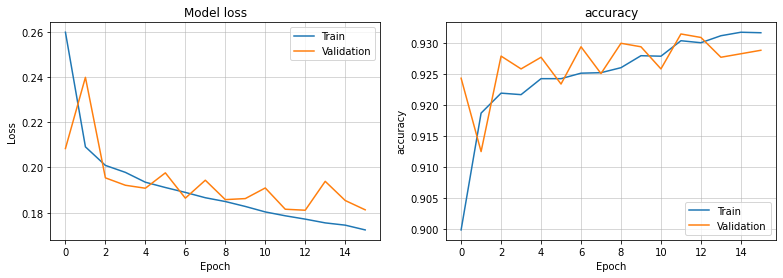

In [67]:
plot_loss(history_fit)

In [68]:
res = model.evaluate(X_test_pad, y_test, verbose = 1)
res

2022-03-09 16:10:51.909312: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1217760000 exceeds 10% of free system memory.


238/238 [==============================] - 15s 64ms/step - loss: 0.1827 - accuracy: 0.9267 - auc: 0.9759 - precision: 0.9659 - recall: 0.8848


[0.1827172487974167,
 0.9266850352287292,
 0.975908100605011,
 0.96590256690979,
 0.8847768902778625]